# Doubly-robust estimation with a causal latent factor model

This notebook is an attempt to reproduce the synthetic data experiment in section 6 of [Doubly Robust Inference in Causal Latent Factor Models](https://arxiv.org/abs/2402.11652) using the MC-EIF one-step corrected estimator described in [Automated Efficient Estimation using Monte Carlo Efficient Influence Functions](https://arxiv.org/abs/2403.00158) and implemented in `chirho.robust`.

In [1]:
%reload_ext autoreload
%autoreload 2

from typing import Callable, Mapping, TypedDict

import numpy as np
import matplotlib.pyplot as plt

import torch

import pyro
import pyro.distributions as dist

import chirho
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition
from chirho.robust.ops import influence_fn
from chirho.robust.handlers.estimators import one_step_corrected_estimator
from chirho.robust.handlers.predictive import BatchedLatents, PredictiveModel

pyro.set_rng_seed(101)
pyro.settings.set(module_local_params=True)

## Introduction: causal effect estimation with missing data and multiple measurements

![Figure1](figures/dr_matcomp.png)

The above image is Figure 1 from the source paper [Doubly Robust Inference in Causal Latent Factor Models](https://arxiv.org/abs/2402.11652)

## Model: low-rank linear latent factor model

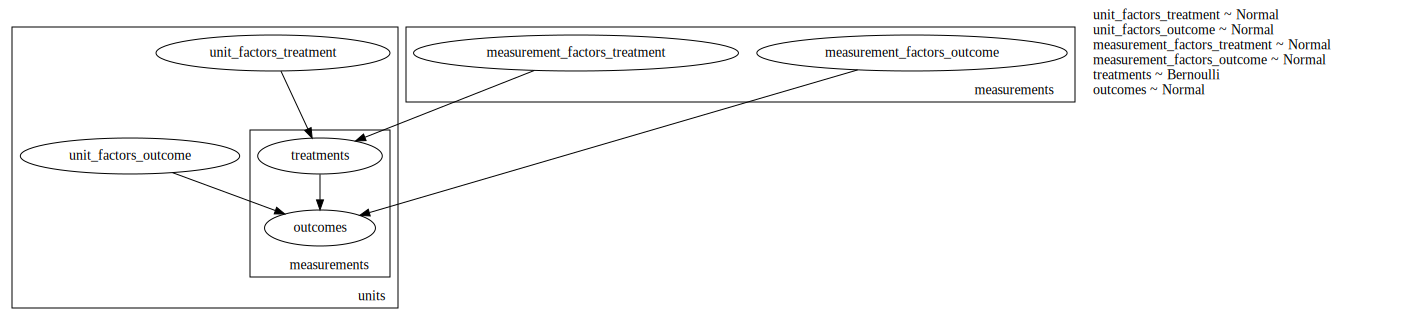

In [2]:
class FactorModel(pyro.nn.PyroModule):
    num_units: int
    num_measurements: int
    num_factors: int

    def __init__(self, num_units: int, num_measurements: int, num_factors: int):
        super().__init__()
        self.num_units = num_units
        self.num_measurements = num_measurements
        self.num_factors = num_factors
        self.unit_plate = pyro.plate("units", self.num_units, dim=-2)
        self.measurement_plate = pyro.plate("measurements", self.num_measurements, dim=-1)
        self.register_buffer("zero", torch.tensor(0.))
        self.register_buffer("one", torch.tensor(1.))

    @property
    def unit_factors_treatment_prior(self) -> dist.Distribution:
        return dist.Normal(self.zero, self.one).expand([self.num_factors]).to_event(1)

    @property
    def unit_factors_outcome_prior(self) -> dist.Distribution:
        return dist.Normal(self.zero, self.one).expand([self.num_factors, 2]).to_event(2)

    @property
    def measurement_factors_treatment_prior(self) -> dist.Distribution:
        return dist.Normal(self.zero, self.one).expand([self.num_factors]).to_event(1)

    @property
    def measurement_factors_outcome_prior(self) -> dist.Distribution:
        return dist.Normal(self.zero, self.one).expand([self.num_factors, 2]).to_event(2)

    def outcome_link_fn(self, outcome_locs: torch.Tensor) -> dist.Distribution:
        return dist.Normal(outcome_locs, self.one)

    def forward(self) -> torch.Tensor:
        with self.unit_plate:
            unit_factors_treatment = pyro.sample("unit_factors_treatment", self.unit_factors_treatment_prior)
            unit_factors_outcome = pyro.sample("unit_factors_outcome", self.unit_factors_outcome_prior)

        with self.measurement_plate:
            measurement_factors_treatment = pyro.sample("measurement_factors_treatment", self.measurement_factors_treatment_prior)
            measurement_factors_outcome = pyro.sample("measurement_factors_outcome", self.measurement_factors_outcome_prior)
            # appease batched einsum by ensuring a batch dimension exists for unit_plate
            if len(measurement_factors_treatment.shape) == 2:
                measurement_factors_treatment = measurement_factors_treatment[None, ...]
            if len(measurement_factors_outcome.shape) == 3:
                measurement_factors_outcome = measurement_factors_outcome[None, ...]

        treatment_logits = torch.einsum("...umk,...umk->...um", unit_factors_treatment, measurement_factors_treatment)
        potential_outcome_locs = torch.einsum("...umkt,...umkt->...umt", unit_factors_outcome, measurement_factors_outcome)
        with self.unit_plate, self.measurement_plate:
            treatments = pyro.sample("treatments", dist.Bernoulli(logits=treatment_logits))
            outcome_locs = torch.where(treatments == 0, potential_outcome_locs[..., 0], potential_outcome_locs[..., 1])
            outcomes = pyro.sample("outcomes", self.outcome_link_fn(outcome_locs))
            return outcomes

model = FactorModel(
    num_units=100,
    num_measurements=10,
    num_factors=3,
)

pyro.render_model(model, render_deterministic=True, render_distributions=True, render_params=True)

## Data: synthetic data-generating process

In [25]:
class FactorModelDataset(TypedDict):
    treatments: torch.Tensor
    outcomes: torch.Tensor

class TrueModel(FactorModel):
    def __init__(self):
        super().__init__(num_units=100, num_measurements=10, num_factors=3)

true_model = TrueModel()

true_dgp: Callable[[], FactorModelDataset] = pyro.infer.Predictive(true_model, return_sites=["treatments", "outcomes"], num_samples=1)

# generate full datasets
train_data: FactorModelDataset = true_dgp()
test_data: FactorModelDataset = true_dgp()

# compute true ATE for evaluation
with torch.no_grad():
    ate_true = sum(do(actions=dict(treatments=torch.tensor(1.)))(true_model)().mean() - do(actions=dict(treatments=torch.tensor(0.)))(true_model)().mean() for _ in range(1000)) / 1000

## Parameter estimation: maximum a posteriori inference (MAP)

In [4]:
class ConditionedFactorModel(pyro.nn.PyroModule):
    model: FactorModel

    def __init__(self, model: FactorModel):
        super().__init__()
        self.model = model

    def forward(self, data: FactorModelDataset) -> torch.Tensor:
        with condition(data=data):
            return self.model()

conditioned_model = ConditionedFactorModel(model)
guide = pyro.infer.autoguide.AutoDelta(conditioned_model)

elbo = pyro.infer.Trace_ELBO()(conditioned_model, guide)

elbo(train_data)  # initialize guide

optim = torch.optim.Adam(elbo.parameters(), lr=0.01)

for step in range(1001):
    optim.zero_grad()
    loss = elbo(train_data)
    loss.backward()
    optim.step()
    if step % 100 == 0:
        print(f"step {step} loss = {loss.item()}")

/home/eli/development/pyro/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'measurements', 'units'}
  warnings.warn(
/home/eli/development/pyro/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'measurements', 'units'}
  warnings.warn(


step 0 loss = 4220.35791015625
step 100 loss = 2997.7568359375
step 200 loss = 2732.638427734375
step 300 loss = 2686.0078125
step 400 loss = 2674.146240234375
step 500 loss = 2669.27392578125
step 600 loss = 2665.63037109375
step 700 loss = 2660.656494140625
step 800 loss = 2655.888671875
step 900 loss = 2653.49267578125
step 1000 loss = 2651.457763671875


## Query: average treatment effect (ATE)

In [16]:
class ATEFunctional(pyro.nn.PyroModule):
    model: FactorModel
    num_samples: int

    def __init__(self, model: FactorModel, *, num_samples: int = 10):
        super().__init__()
        self.model = model
        self.num_samples = num_samples
        self.register_buffer("zero", torch.tensor(0.))
        self.register_buffer("one", torch.tensor(1.))

    def forward(self) -> torch.Tensor:
        with MultiWorldCounterfactual() as mwc:
            with BatchedLatents(num_particles=self.num_samples):
                with do(actions=dict(treatments=(self.zero, self.one))):
                    outcomes = self.model()

                outcomes_treated = gather(outcomes, IndexSet(treatments={2}))
                outcomes_untreated = gather(outcomes, IndexSet(treatments={1}))
                ites = outcomes_treated - outcomes_untreated
                return pyro.deterministic("ate", ites.mean((-1, -2), keepdim=True), event_dim=0).mean()

target_functional = lambda m: ATEFunctional(m, num_samples=10)
predictive_model: PredictiveModel[[], torch.Tensor] = PredictiveModel(model, guide)

### Plug-in estimator

In [17]:
plugin_estimator: Callable[[], torch.Tensor] = target_functional(predictive_model)

with torch.no_grad():
    ate_plugin = plugin_estimator()

### One-step corrected estimator

In [18]:
corrected_functional = one_step_corrected_estimator(target_functional, test_data, num_samples_outer=101)

dr_estimator: Callable[[], torch.Tensor] = corrected_functional(predictive_model)

with torch.no_grad():
    ate_dr = dr_estimator()

## Results

Text(0.5, 1.0, 'ATE estimates')

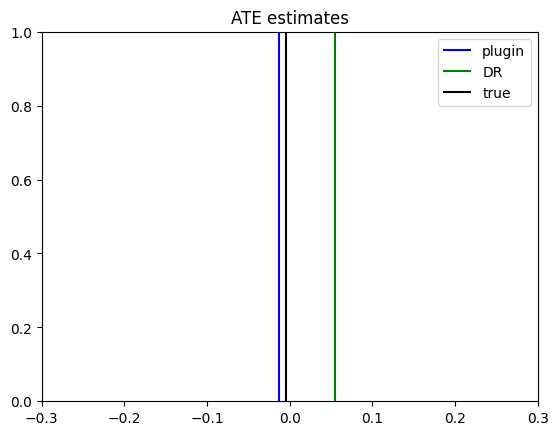

In [24]:
plt.vlines(ate_plugin.detach().cpu().numpy(), 0, 1, label="plugin", color="b")
plt.vlines(ate_dr.detach().cpu().numpy(), 0, 1, label="DR", color="g")
plt.vlines(ate_true.detach().cpu().numpy(), 0, 1, label="true", color="black")
plt.xlim(-0.3, 0.3)
plt.ylim(0, 1)
plt.legend()
plt.title("ATE estimates")